In [1]:
import numpy as np
import networkx as nx
import math
import random
#from sklearn.cluster import KMeans
from typing import List
import matplotlib
import colorsys
from VRP import VRP 
from numbaVRP import *
from ORToolsVRP import get_ORTools_result
%load_ext line_profiler


In [2]:
#%lprun -f numba_fitness numba_fitness(vrp.population[0],vrp.capacities,edge_weights_numba,vrp.truck_capacity)


[66  3  1 10 43 18 63 49 56 17 11 16 25 38 14 36 64 53 20  0 51 26 21 61
 54 32 19 13 42 12 22 52  8 15 34 33 35 47 57  5 55 69  7 39 27 65 46 30
  2 67 44 58  9 60 40 24 50 62 23 68 48  6 41  4 28 37 29 45 59 31]
7516.090804321896
[['B', 66, 3, 1, 10, 43, 18, 'B'], ['B', 63, 49, 56, 17, 11, 'B'], ['B', 16, 25, 38, 14, 'B'], ['B', 36, 64, 53, 20, 0, 'B'], ['B', 51, 26, 21, 61, 54, 32, 'B'], ['B', 19, 13, 42, 12, 22, 'B'], ['B', 52, 8, 15, 34, 33, 35, 'B'], ['B', 47, 57, 5, 55, 69, 7, 'B'], ['B', 39, 27, 65, 46, 30, 'B'], ['B', 2, 67, 44, 58, 9, 'B'], ['B', 60, 40, 24, 50, 62, 23, 'B'], ['B', 68, 48, 6, 41, 4, 'B'], ['B', 28, 37, 29, 45, 59, 'B'], ['B', 31, 'B']]


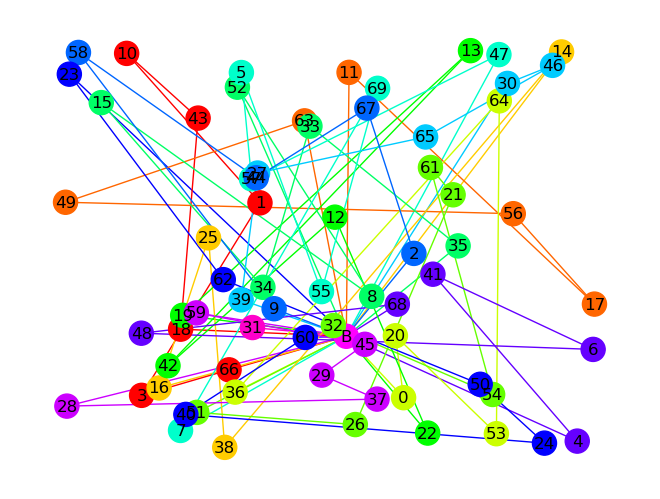

In [3]:
seed = 30
n_clients = 70
np.random.seed(seed)
random.seed(seed)
#vrp = VRP(200,200,100,20)
vrp = VRP(200,200,n_clients,100)
vrp.init_random_population()
#vrp.population[0] = [2,0,3,1]
print(vrp.population[0])
distance,routes = vrp.fitness_function(0)
print(distance)
print(routes)
vrp.draw_chromosome_paths()
#vrp.capacities[0]
chs = list()
fs = list()

3112.8968567743173


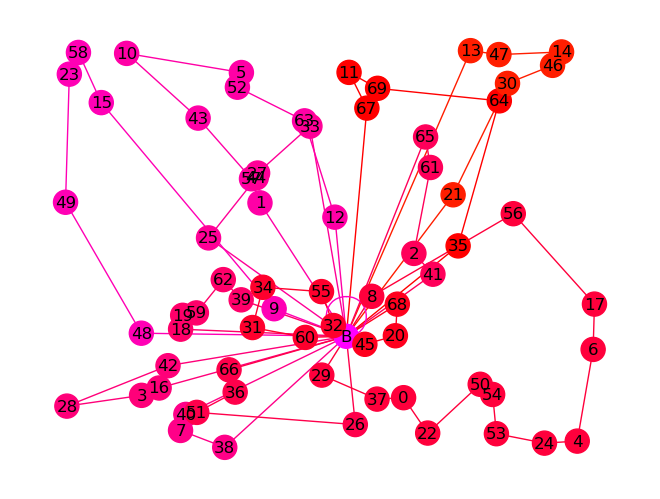

In [4]:
optimal_fitness = get_ORTools_result(vrp)
print(optimal_fitness)

In [6]:
total_epochs = 500
iterations_per_epoch = 20000
epochs_before_restart = 2
decimation = 4
mut = 0.15
#multiplier_restart = 10

In [7]:

import time

print("hello")


hello


In [8]:
start = time.time()
edge_weights_py = nx.get_edge_attributes(vrp.graph,'weight')
edge_weights_numba = Dict.empty(
        key_type=types.UniTuple(types.int64, 2), 
        value_type=types.float_
    )
for (k1,k2),v in edge_weights_py.items():
    edge_weights_numba[(k1,k2)]=v
    edge_weights_numba[(k2,k1)]=v
#%lprun -f numba_run
#x,y = numba_run(vrp.population,vrp.capacities,edge_weights_numba,vrp.truck_capacity,vrp.n_clients,n_iterations=100)
#%lprun -f vrp.x__fast_fitness_function vrp.x__fast_fitness_function(vrp.population[0])
tries=0
previous_f = -1
equal_fitness_counter = 0 
try:
    while tries < total_epochs:
        print(tries)
        if equal_fitness_counter >= epochs_before_restart:#*((multiplier_restart if min(fs) == f else 1) if fs else 1):
            old_best = vrp.population[0].copy()#
            vrp.init_random_population(False)
            vrp.population[0] = old_best#
            equal_fitness_counter = 0
            print("Restarting...\n")
        ch, f,pop = numba_run(vrp.population,vrp.capacities,edge_weights_numba,vrp.truck_capacity,vrp.n_clients,
                              n_iterations=iterations_per_epoch,decimation_factor=decimation,mutation_p=mut)
        chs.append(ch)
        fs.append(f)
        
        f, routes = vrp.fitness_function(0)
        new_routes= []
        for route in routes:
            for i in range(len(route)):
                if route[i] == 'B':
                    route[i] = -1 
            tsp_solution = nx.approximation.traveling_salesman_problem(vrp.graph,nodes = route)
            tsp_solution=tsp_solution[1:-1]
            new_routes= new_routes +tsp_solution
        vrp.population[0] = new_routes
        print(f,end=',',flush=True)
        tries+=1
        if previous_f == f:
            equal_fitness_counter +=1
        else:
            equal_fitness_counter = 0
        previous_f  = f
except KeyboardInterrupt:
    pass

/home/fogliodicarta/miniconda3/envs/vrp/lib/python3.12/site-packages/numba/typed/typeddict.py:34: NumbaTypeSafetyWarning: unsafe cast from float64 to float32. Precision may be lost.
  d[key] = value


0
5614.3692928424025,1
5614.3692928424025,2
5614.3692928424025,3
Restarting...

5470.643329926819,4
5305.193221991938,5
5137.205451964456,6
5137.205451964456,7
5137.205451964456,8
Restarting...

5128.980342182197,9
5128.980342182197,10
5128.980342182197,11
Restarting...

5149.857239732949,12
5149.857239732949,13
5149.857239732949,14
Restarting...

5145.642283586217,15
5145.642283586217,16
5145.642283586217,17
Restarting...

5174.04695827129,18
5174.04695827129,19
5174.04695827129,20
Restarting...

5082.846637816369,21
5082.846637816369,22
5082.846637816369,23
Restarting...

5108.333843744588,24
5108.333843744588,25
5108.333843744588,26
Restarting...

5108.333843744588,27
5108.333843744588,28
Restarting...

5111.324710341949,29
5111.324710341949,30
5111.324710341949,31
Restarting...

5093.167659081482,32
5093.167659081482,33
5093.167659081482,34
Restarting...

5113.189119606663,35
5113.189119606663,36
5113.189119606663,37
Restarting...

5088.681177698371,38
5088.681177698371,39
5088.681

SystemError: CPUDispatcher(<function numba_run at 0x784d0a3b2980>) returned a result with an exception set

In [9]:

end = time.time()
print(end - start)
len(fs)

1207.7493641376495


49

In [10]:
print(f)
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)


5130.048380207546


5082.84619140625


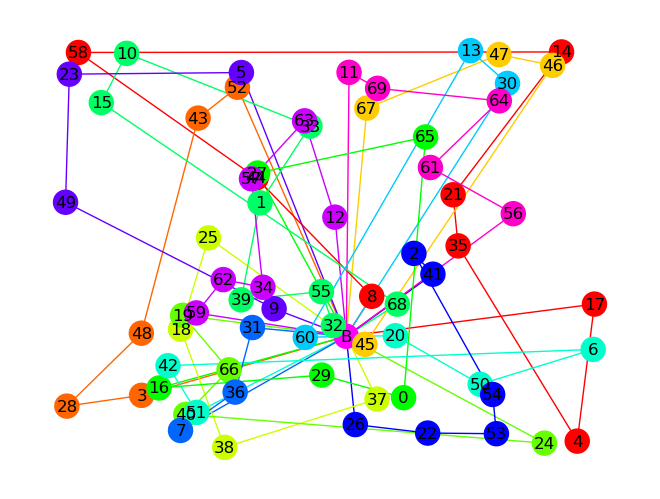

In [11]:
import matplotlib.pyplot as plt
print(min(fs))
#print(fs[100])
vrp.population[0] = chs[fs.index(min(fs))]
vrp.draw_chromosome_paths(0)
plt.savefig("GAsolution_15cities.png")

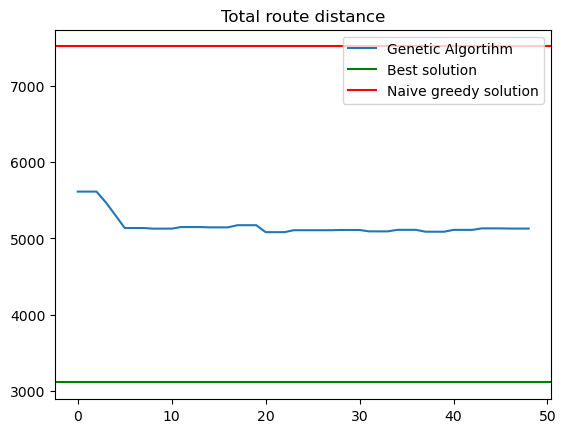

In [12]:
import matplotlib.pyplot as plt
plt.plot(range(len(fs)),(fs[:]),label="Genetic Algortihm")
plt.axhline(optimal_fitness,color='g',label="Best solution")
plt.axhline(distance,color='r',label="Naive greedy solution")

#plt.axvline(1000,color='black')
#plt.axvline(2000,color='black')
#plt.axvline(3000,color='black')
plt.legend()
plt.title("Total route distance")
plt.savefig(f"seed{seed}nodes{n_clients}mut{mut}iter{iterations_per_epoch}decim{decimation}restart{epochs_before_restart}.png")
#len(fs)=100

5082.84619140625


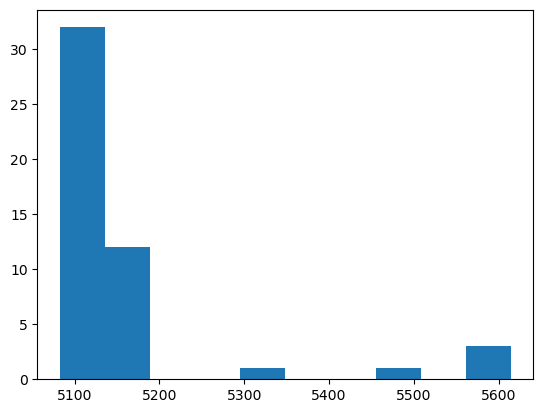

In [13]:
print(min(fs))
len(np.unique(vrp.population,axis=1))
hh = plt.hist(fs)

In [4]:
#%lprun -f vrp.run
vrp.run(100)

(array([ 4,  1, 16, 17, 10, 11,  5, 14,  6,  3,  9, 18, 13,  8, 19, 12,  7,
        15,  0,  2]),
 1853.0205727475663)

In [14]:
%lprun -f vrp.run vrp.run(1000)

Timer unit: 1e-09 s

Total time: 13.0874 s
File: /tmp/ipykernel_24474/3206351418.py
Function: run at line 181

Line #      Hits         Time  Per Hit   % Time  Line Contents
   181                                               def run(self,n_iterations : int = 100):
   182         1       2639.0   2639.0      0.0          kept_population = len(self.population)//50
   183         1       7763.0   7763.0      0.0          fitnesses = np.empty(len(self.population))
   184         1       1209.0   1209.0      0.0          iteration_best_fitness = float('inf')
   185         1        317.0    317.0      0.0          iteration_best_chromosome = None
   186                                                   
   187         1        733.0    733.0      0.0          best_fitness = float('inf')
   188         1        197.0    197.0      0.0          best_chromosome = None
   189                                           
   190         1       5357.0   5357.0      0.0          new_population = n

In [9]:
%%heat
tries = 0
try:
    while tries < 25:
        #print(tries)
        #vrp.init_random_population(False)
        ch, f = vrp.run(1000)
        chs.append(ch)
        fs.append(f)
        print(f)
        tries+=1
except KeyboardInterrupt:
    pass



#print(ch)
#print(f)
#vrp.draw_chromosome_paths(0)


UsageError: Cell magic `%%heat` not found.


In [27]:
min(fs)
(fs)


[1707.9957972627424,
 1600.1258666503427,
 1512.6432743690295,
 1431.6009183045883,
 1431.6009183045883,
 1399.7748452316064,
 1336.6912548060843,
 1292.2494858976513,
 1292.2494858976513,
 1292.2494858976513,
 1292.2494858976513,
 1292.2494858976513,
 1292.2494858976513]

In [8]:
import pickle
pickle.dump(chs, open('aaaaA_chs.pickle', 'wb'))
pickle.dump(fs, open('aaaaA_fs.pickle', 'wb'))

In [54]:
'''import pickle
pickle.dump(chs, open('___chs.pickle', 'wb'))
pickle.dump(fs, open('____fs.pickle', 'wb'))'''

In [12]:
import pickle
chs = pickle.load(open('Restartchs_10000epoch_thirdcull.pickle', 'rb'))
fs = pickle.load(open('Restartfs_10000epoch_thirdcull.pickle', 'rb'))
fs


[1405.43505859375,
 1405.43505859375,
 1405.43505859375,
 1405.43505859375,
 1405.43505859375,
 1405.43505859375,
 1387.9539794921875,
 1327.7940673828125,
 1327.7940673828125,
 1327.7940673828125,
 1327.7940673828125,
 1327.7940673828125,
 1327.7940673828125,
 1327.7940673828125,
 1523.3311767578125,
 1523.3311767578125,
 1496.6910400390625,
 1496.6910400390625,
 1496.6910400390625,
 1496.6910400390625,
 1496.6910400390625,
 1496.6910400390625,
 1496.6910400390625,
 1625.792236328125,
 1506.4114990234375,
 1430.96923828125,
 1410.25732421875,
 1410.25732421875,
 1410.25732421875,
 1406.329833984375,
 1406.329833984375,
 1406.329833984375,
 1406.329833984375,
 1406.329833984375,
 1405.1552734375,
 1405.1552734375,
 1405.1552734375,
 1405.1552734375,
 1405.1552734375,
 1405.1552734375,
 1405.1552734375,
 1556.771240234375,
 1552.6444091796875,
 1544.3697509765625,
 1520.1282958984375,
 1520.1282958984375,
 1520.1282958984375,
 1520.1282958984375,
 1520.1282958984375,
 1520.1282958984375

In [28]:
vrp.population[0] = chs[-1]

In [13]:
len(fs)

125

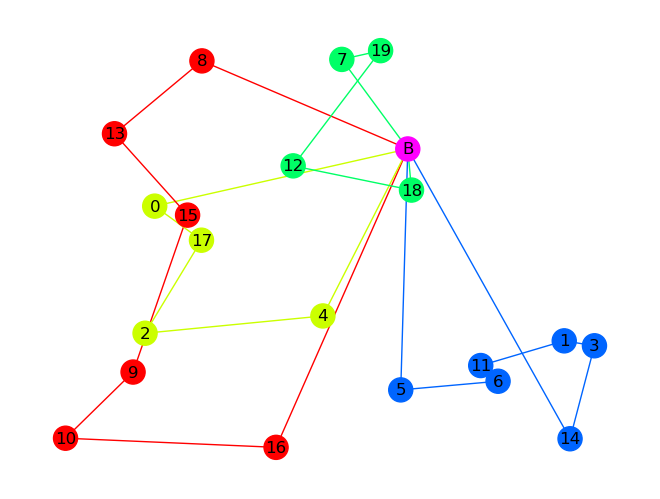

In [29]:
vrp.draw_chromosome_paths(0)

In [34]:
list(range(0,10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [76]:
vrp.capacities[0][3]=1
vrp.fitness_function(0)
a = vrp.graph.edges[(-1,0)]['weight']*2
a
b= vrp.graph.edges[(-1,1)]['weight'] +vrp.graph.edges[(1,2)]['weight'] +vrp.graph.edges[(2,-1)]['weight']
b
c = vrp.graph.edges[(-1,3)]['weight']*2
c
a+b+c

Ending route: truck number 0 filled with 39.696531088435066 kg
Ending route: truck number 1 filled with 43.694695351962984 kg
Ending route: truck number 2 filled with 41.90858063351081 kg
Ending route: truck number 3 filled with 38.406295553502844 kg
Ending route: truck number 4 filled with 47.103308697080706 kg
Ending route: truck number 5 filled with 49.74689752385468 kg
Ending route: truck number 6 filled with 43.85915787615736 kg
Ending route: truck number 7 filled with 46.70247920292772 kg
Ending route: truck number 8 filled with 39.49256344680498 kg
Ending route: truck number 9 filled with 44.607578253990425 kg
Ending route: truck number 10 filled with 45.06038841808062 kg
Ending route: truck number 11 filled with 48.924332933777514 kg
Ending route: truck number 12 filled with 47.73214900683785 kg
Ending route: truck number 13 filled with 42.42996908958217 kg
Ending route: truck number 14 filled with 42.36976389303656 kg
Ending route: truck number 15 filled with 34.93027903131236

(27049.25113886217,
 [['B', 103, 33, 188, 194, 'B'],
  ['B', 138, 154, 39, 152, 3, 'B'],
  ['B', 169, 92, 185, 164, 'B'],
  ['B', 58, 66, 78, 'B'],
  ['B', 72, 187, 181, 175, 36, 114, 'B'],
  ['B', 168, 65, 54, 22, 81, 130, 'B'],
  ['B', 42, 87, 157, 93, 193, 147, 'B'],
  ['B', 67, 21, 80, 25, 105, 10, 109, 88, 'B'],
  ['B', 134, 155, 180, 159, 198, 9, 'B'],
  ['B', 1, 117, 94, 149, 50, 95, 'B'],
  ['B', 113, 34, 45, 120, 'B'],
  ['B', 148, 47, 142, 12, 97, 170, 'B'],
  ['B', 115, 197, 119, 151, 63, 40, 'B'],
  ['B', 77, 49, 59, 118, 171, 'B'],
  ['B', 101, 7, 182, 23, 158, 'B'],
  ['B', 71, 86, 156, 'B'],
  ['B', 11, 102, 96, 'B'],
  ['B', 15, 123, 53, 124, 30, 'B'],
  ['B', 14, 13, 48, 106, 'B'],
  ['B', 17, 167, 19, 133, 174, 173, 'B'],
  ['B', 100, 160, 84, 79, 20, 46, 128, 178, 'B'],
  ['B', 31, 163, 43, 129, 5, 37, 32, 55, 'B'],
  ['B', 172, 196, 62, 195, 91, 'B'],
  ['B', 76, 2, 0, 161, 199, 'B'],
  ['B', 126, 60, 57, 153, 125, 'B'],
  ['B', 166, 137, 89, 90, 107, 'B'],
  ['B', 

268.5903149054003

142.78387965009966

349.797698178117

761.1718927336169

TypeError: 'generator' object is not callable